# Neural Networks

## Neural Networks

&ensp; &ensp; &ensp; &ensp; **Neural networks** are computational models inspired by the structure of the human brain, designed to recognize patterns and make predictions. They consist of layers of interconnected nodes (often called neurons) that process information through mathematical operations.

A basic neural network has the following structure:

1. **Input Layer**: The first layer receives raw data, like images, text, or numerical values. Each node in this layer represents an input dimension.
2. **Hidden Layers**: The intermediate layers are between the input and output layers, and process the information. Each hidden layer transforms data from the previous layer, allowing the network to progressively learn and recognize patterns.
3. **Output Layer**: The final layer provides the network’s output, such as classifying an image or predicting a value.

```{figure} ../images/neural-network.png
---
width: 340px
name: neural-network
---
Basic Structure of a Neural Network
```



(1.3)=
## Neurons

&ensp; &ensp; &ensp; &ensp; A **neuron** is a fundamental unit that takes in multiple inputs and processes them to produce a single output. As shown above in [*Fig. 1.2*](neural-network), each neuron in the hidden and output layers connects to all the neurons in the previous layer. These connections have associated values, known as **weights**, which are adjusted by the model. The weights represent the strength of connection between the neurons. A greater weight indicates a stronger connection.

&ensp; &ensp; &ensp; &ensp; To calculate the output of a neuron, all the inputs to the neuron ($x_{1}, x_{2}, \dots, x_{d}$) are multiplied by their corresponding connection weights ($w_{1}, w_{2}, \dots, w_{d}$), and the products are summed. A numerical value, called the **bias** ($b$), is then added to the weighted sum. Finally, the result is passed through an **activation function** ($\sigma$) that returns the output of the neuron, often called the neuron's **activation value** ($h$).

```{figure} ../images/neuron.png
---
width: 250px
name: neuron
---
Structure of a Neuron
```

```{admonition} Neuron's output
<p class="bottom-margin">The activation value of a neuron is given by the formula:</p>

$$
\small
h = \sigma(x_{1}w_{1} + x_{2}w_{2} + \dots + x_{d}w_{d} + b)
$$

<p class="no-top-margin">where:</p>

- $d$: Dimensionality of the input vector.
```


```{admonition} Neuron's output (dot product)
<p class="bottom-margin">Using a dot product to express the weighted sum, the formula is:</p>

$$
\small
h
=
\sigma\left(
\begin{bmatrix}
x_{1} & x_{2} & \dots & x_{d}
\end{bmatrix}
\cdot
\begin{bmatrix}
w_{1} \\
w_{2} \\
\vdots \\
w_{d}
\end{bmatrix}
+
b
\right)
$$

<p class="no-top-margin">where:</p>

- $d$: Dimensionality of the input vector.
```

```{important}
Please note that the ouput of a neuron is one of the inputs to all the neurons in the next layer.
```



## PyTorch

&ensp; &ensp; &ensp; &ensp; To build our neural networks, we will use **PyTorch**, an open-source machine learning library widely used because of its flexibility, ease of use, and efficient computation. The following code sets up the environment for working with PyTorch:

In [2]:
# import PyTorch
import torch
import torch.nn.functional as F

# set print options to 2 decimal places
torch.set_printoptions(precision=2)

````{admonition} PyTorch Tensors
<p style="margin: 15px 1.4rem  15px 1.4rem ;">PyTorch provides <strong>tensors</strong>, which are multi-dimensional arrays optimized for GPU processing. Depending on their dimensions, we will refer to them differently:</p>

- A 1-dimensional tensor is called a **vector**. A vector with shape (3) would look like this:

```python
tensor([1, 2, 3])
```

- A 2-dimensional tensor is called a **matrix**. A matrix with shape (2, 3) would look like this:

```python
tensor([[1, 2, 3],
        [4, 5, 6]])
```

- A 3 or more dimensional tensor is called an **n-dimensional tensor**. A 3-dimensional tensor with shape (2, 2, 3) would look like this:

```python
tensor([[[1, 2, 3],
        [4, 5, 6]],
        [[7, 8, 9],
        [10, 11, 12]]])
```
````


## How Neural Networks Learn

Neural networks use supervised learning to fine-tune their parameters (weights and biases) by minimizing the loss function. This process involves repeating these four steps during training:

1. **Forward Pass:** Process input data through the network to generate predictions.
2. **Loss Function:** Measure the error by comparing predictions with actual target values.
3. **Backward Pass:** Calculate gradients of the loss function with respect to the network's parameters using backpropagation.
4. **Update Parameters:** Adjust weights and biases to reduce the loss, guided by the computed gradients.




## Example

To better understand how neural networks learn, we will create a simple neural network that converts 3-digit binary numbers into their decimal equivalents.

```{admonition} Conversion binary to decimal
<p class="bottom-margin">The conversion from a 3-digit binary number (<i>b2b1b0</i>) to its decimal equivalent (<i>D</i>) follows the formula:</p>

$$
\small
D = b_2 \cdot 2^2 + b_1 \cdot 2^1 + b_0 \cdot 2^0
$$

<p class="no-top-margin">where:</p>

- $b_2, b_1, b_0$ are the binary digits 0 or 1. a

The table below shows the equivalences:

| Binary | Decimal |
|--------|---------|
| 000    | 0       |
| 001    | 1       |
| 010    | 2       |
| 011    | 3       |
| 100    | 4       |
| 101    | 5       |
| 110    | 6       |
| 111    | 7       |

```

Although our neural network won't know this formula, it will learn the relationship between 3-digit binary and decimal numbers through training. We will use the following **input examples** and corresponding **labels** to train the model:

In [3]:
x = torch.tensor([[0, 0, 0], 
                  [0, 0, 0], 
                  [0, 0, 1], 
                  [0, 0, 1], 
                  [0, 1, 0], 
                  [0, 1, 0], 
                  [0, 1, 1], 
                  [0, 1, 1], 
                  [1, 0, 0], 
                  [1, 0, 0], 
                  [1, 0, 1], 
                  [1, 0, 1], 
                  [1, 1, 0], 
                  [1, 1, 0], 
                  [1, 1, 1], 
                  [1, 1, 1]]).float()

labels = torch.tensor([0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7])

```{important}
The input to a neuron must be floats (decimals)
```

### Network Structure

&ensp; &ensp; &ensp; &ensp; The neural network will have the following structure


```{figure} ../images/binary-to-decimal.png
---
width: 340px
name: binary-to-decimal
---
Structure of Neural Network
```


To begin, we will initialize the network parameters randomly. For simplicity, we will exclude bias terms and activation functions at this stage.

```{admonition} Help
:class: dropdown
The `torch.randn` function generates a tensor filled with random numbers drawn from a standard normal distribution (mean = 0, standard deviation = 1). For more information, please refer to the [PyTorch documentation](https://pytorch.org/docs/stable/generated/torch.randn.html).
```

```{admonition} Help
:class: dropdown
The `requires_grad=True` argument indicates that the tensor should track gradients for operations. This will enable to run `loss.backward()` in the backward pass.
```

In [3]:
def initialize_nn():

    # seed the random number generator for reproducibility
    g = torch.Generator().manual_seed(1)

    # intitialize randomly weight matrices and bias vectors
    W1 = torch.randn((3, 10), generator=g)
    b1 = torch.randn(10,      generator=g)
    W2 = torch.randn((10, 8), generator=g)
    b2 = torch.randn(8,       generator=g)

    # list of parameters
    parameters = [W1, b1, W2, b2]

    # track gradients
    for p in parameters:
        p.requires_grad = True
    
    return parameters

parameters = initialize_nn()
W1, b1, W2, b2 = parameters

### Forward Pass

&ensp; &ensp; &ensp; &ensp; In the **forward pass**, the input data flows through the network, layer by layer, to produce the network's output.


```{admonition} Neuron's output (dot product)
<p class="bottom-margin">In section <a href="#1.3"><i>1.3. Neurons</i></a>, we saw that the output of a neuron is given by the formula:</p>

$$
\small
h
=
\sigma\left(
\begin{bmatrix}
x_{1} & x_{2} & \dots & x_{d}
\end{bmatrix}
\cdot
\begin{bmatrix}
w_{1} \\
w_{2} \\
\vdots \\
w_{d}
\end{bmatrix}
+
b
\right)
$$

<p class="no-top-margin">where:</p>

- $d$: Dimensionality of the input vector.
```



````{admonition} Layer's output (single example)
<p class="bottom-margin">We can adjust the previous formula and use a weight matrix to obtain the output of a layer, that is, the activation values of all the neurons in the layer:</p>

$$
\small
\begin{bmatrix}
h_{1} & h_{2} & \dots & h_{m}
\end{bmatrix}
=
\sigma\left(
\begin{bmatrix}
x_{1} & x_{2} & \dots & x_{d}
\end{bmatrix}
\cdot
\begin{bmatrix}
w_{11} & w_{12} & \dots & w_{1m} \\
w_{21} & w_{22} & \dots & w_{2m} \\
\vdots & \vdots & \ddots & \vdots \\
w_{d1} & w_{d2} & \dots & w_{dm} \\
\end{bmatrix}
+
\begin{bmatrix}
b_{1} & b_{2} & \dots & b_{m}
\end{bmatrix}
\right)
$$

<p class="no-top-margin">where:</p>

- $d$: Dimensionality of the input vector.
- $m$: Number of neurons in the layer.

```{important}
Each column of the weight matrix contains the weights of the connections between a single neuron in the layer and all the neurons in the previous layer.
```

````


````{admonition} Layer's output (multiple example)
<p class="bottom-margin">Matrix multiplication enables us to efficiently calculate in parallel the output of a layer for several input examples:</p>

$$
\tiny
\begin{bmatrix}
h_{11} & h_{12} & \dots & h_{1m} \\
h_{21} & h_{22} & \dots & h_{2m} \\
\vdots & \vdots & \ddots & \vdots \\
h_{N1} & h_{N2} & \dots & h_{Nm}
\end{bmatrix}
=
\sigma\left(
\begin{bmatrix}
x_{11} & h_{12} & \dots & h_{1d} \\
x_{21} & h_{22} & \dots & h_{2d} \\
\vdots & \vdots & \ddots & \vdots \\
x_{N1} & h_{N2} & \dots & h_{Nd}
\end{bmatrix}
\times
\begin{bmatrix}
w_{11} & w_{12} & \dots & w_{1m} \\
w_{21} & w_{22} & \dots & w_{2m} \\
\vdots & \vdots & \ddots & \vdots \\
w_{d1} & w_{d2} & \dots & w_{dm} \\
\end{bmatrix}
+
\begin{bmatrix}
b_{1} & b_{2} & \dots & b_{k}
\end{bmatrix}
\right)
$$

<p class="no-top-margin">where:</p>

- $d$: Dimensionality of the input vector.
- $m$: Number of neurons in the layer.
- $N$: Number of examples in a batch.

```{important}
Each row of the output matrix contains the activation values of all the neurons in the layer for a single input example.
```

````

In [4]:
# matrix multiplication
h = x @ W1 + b1    # (16,10) = (16,3) x (3,10)
o = h @ W2 + b2    # (16,8) = (16,10) x (10,8)

### Loss Function

&ensp; &ensp; &ensp; &ensp; A **loss function** is a mathematical representation that quantifies how well a machine learning model is performing. It measures the difference between the model's predicted outputs and the actual outputs from the dataset (the **targets**).

There are various types of loss functions, each suitable for different tasks:
- Regression Tasks: Mean Squared Error (MSE) and Mean Absolute Error (MAE).
- Classification Tasks: Cross-Entropy Loss and Hinge Loss.

In [5]:
# calculate loss
loss = F.cross_entropy(o, labels)
print(f"Loss: {loss.item():.2f}")

Loss: 11.31


### Backwards pass

The network calculates gradients by propagating the error backward through the layers, determining how much each parameter contributed to the error. During **backpropagation**, the neural network computes the **gradient of the loss function** with respect to all its parameters by applying the chain rule of calculus.

To compute all the gradients, we will use the PyTorch function `loss.backward()` which kept track of all the operations during the forwards pass. In  [](ch3.ipynb) we will perform a backward pass manually to better understand how backpropagation works and how the gradients are calculated.

In [6]:
# reset gradients to None
for p in parameters:
    p.grad = None

# calculate gradients
loss.backward()

### Update Parameters

The calculated gradients are used to adjust the weights and biases through an optimization algorithm to minimize the loss function. Once the gradients have been computed, the neural network progresively **updates its parameters** trying minimize the loss function. The most common optimization techniques for updating the parameters are **gradient descent**, **stochastic gradient descent (SGD)**, and **Adam**.

A **gradient** is a vector that represents the rate of change of a function with respect to its input variables. By default, gradients point in the **direction of steepest ascent**, that is, the direction in which the function increases the fastest. Since we want to minimize the loss function, we will move in the opposite direction of the gradients. 




**Gradient descent** is an optimization algorithm used to minimize a function, frequently used in neural networks training to minimize the loss function.

Gradient descent updates each parameter by subtracting a fraction of the gradient from its current value, scaled by a factor known as the **learning rate**. The learning rate determines the size of the steps we take towards the minimum. A smaller learning rate results in more precise but slower convergence, while a larger learning rate can speed up convergence but may risk overshooting the minimum. The parameter update rule for gradient descent can be expressed mathematically as:

$$
\theta = \theta - \eta \nabla L(\theta)
$$

Where:
- $\theta$ represents the parameters of the neural network
- $\eta$ is the learning rate
- $\nabla L(\theta)$ is the gradient of the loss function with respect to the parameters.

In [7]:
lr = 0.1 # learning rate

# update parameters
for p in parameters:
    p.data += -lr * p.grad

### Training

During **training**, a neural network iteratively makes a forward pass, calcules the loss, makes a backward pass and updates its parameters. Each iteration is usually called a **training step**.

In [20]:
parameters = initialize_nn()
W1, b1, W2, b2 = parameters

In [21]:
epochs = 100      # train iterations
lr = 0.1            # learning rate

# list to keep track of the loss in each step
loss_graph = []

for epoch in range(epochs):
    
    # forward pass
    h = x @ W1 + b1    # (16,10) = (16,3) x (3,10)
    o = h @ W2 + b2    # (16,8) = (16,10) x (10,8)

    # calculate loss
    loss = F.cross_entropy(o, labels)
    loss_graph.append(loss.item())
    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Step: {epoch:2d}/{epochs}     Loss: {loss.item():.4f}")
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    for p in parameters:
        p.data += -lr * p.grad

Step:  0/100     Loss: 11.3085
Step: 10/100     Loss: 2.3920
Step: 20/100     Loss: 1.2069
Step: 30/100     Loss: 0.7290
Step: 40/100     Loss: 0.5013
Step: 50/100     Loss: 0.3736
Step: 60/100     Loss: 0.2934
Step: 70/100     Loss: 0.2389
Step: 80/100     Loss: 0.1999
Step: 90/100     Loss: 0.1708
Step: 99/100     Loss: 0.1504


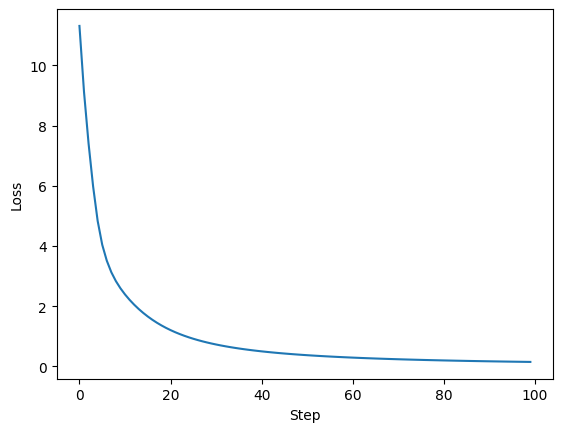

In [22]:
import matplotlib.pyplot as plt

plt.plot(loss_graph)
plt.xlabel('Epoch')
plt.ylabel('Loss');

In [49]:
test = torch.tensor([1,0,1]).float()
test

tensor([1., 0., 1.])

In [50]:
h1 = test @ W1 + b1    # (16,10) = (16,3) x (3,10)
o = h1 @ W2 + b2    # (16,8) = (16,10) x (10,8)